## Setup

### Install dependencies

In [31]:
! pip install transformers==4.31.0
! pip install datasets==2.13.1
! pip install pandas==2.0.3
! pip install numpy==1.25.1
! pip install matplotlib==3.7.2
! pip install seaborn==0.12.2
! pip install scikit-learn
! pip install transformers[torch]
! pip install accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### Import dependencies

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

## Data exploration

### Load data into dataframe

In [33]:
df = pd.read_json("final-data.json")
df

,text,license
0,Attribution-NonCommercial-NoDerivs 2.0 Copyrig...,CC-BY-NC-ND-2.0
1,Attribution-NonCommercial-NoDerivs 2.0 Copyrig...,CC-BY-NC-ND-2.0
2,Attribution-NonCommercial-NoDerivs 2.0 Copyrig...,CC-BY-NC-ND-2.0
3,Attribution-NonCommercial-NoDerivs 2.0 Copyrig...,CC-BY-NC-ND-2.0
4,Attribution-NonCommercial-NoDerivs 2.0 Copyrig...,CC-BY-NC-ND-2.0
...,...,...
10895,MIT License Copyright (c) 2019 Rolando Santama...,MIT
10896,MIT License Copyright (c) 2019 Rolando Santama...,MIT
10897,MIT License Copyright (c) 2019 Rolando Santama...,MIT
10898,MIT License Copyright (c) 2019 Rolando Santama...,MIT


In [34]:
df['text'] = df['text'].str.lower()
df

,text,license
0,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0
1,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0
2,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0
3,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0
4,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0
...,...,...
10895,mit license copyright (c) 2019 rolando santama...,MIT
10896,mit license copyright (c) 2019 rolando santama...,MIT
10897,mit license copyright (c) 2019 rolando santama...,MIT
10898,mit license copyright (c) 2019 rolando santama...,MIT


In [35]:
df.shape

(10900, 2)

### Drop rows that have OTHER and NOASSERTION license values

In [36]:

df = df[df['license'] != 'OTHER']
df = df[df['license'] != 'NOASSERTION']
df.shape

(10662, 2)

### Unique licenses

In [37]:
len(df['license'].unique())

134

In [38]:
license_df = df['license'].value_counts().to_frame('count').rename_axis('license').reset_index()
license_df


,license,count
0,ECL-2.0,182
1,GPL-3.0-only,182
2,UPL-1.0,181
3,CC-BY-NC-4.0,176
4,CC-BY-SA-4.0,173
...,...,...
129,ODC-By-1.0,26
130,CC-BY-NC-SA-2.0,26
131,X11,25
132,CC-BY-SA-3.0,14


### Distribution of licenses

<Axes: xlabel='license', ylabel='count'>

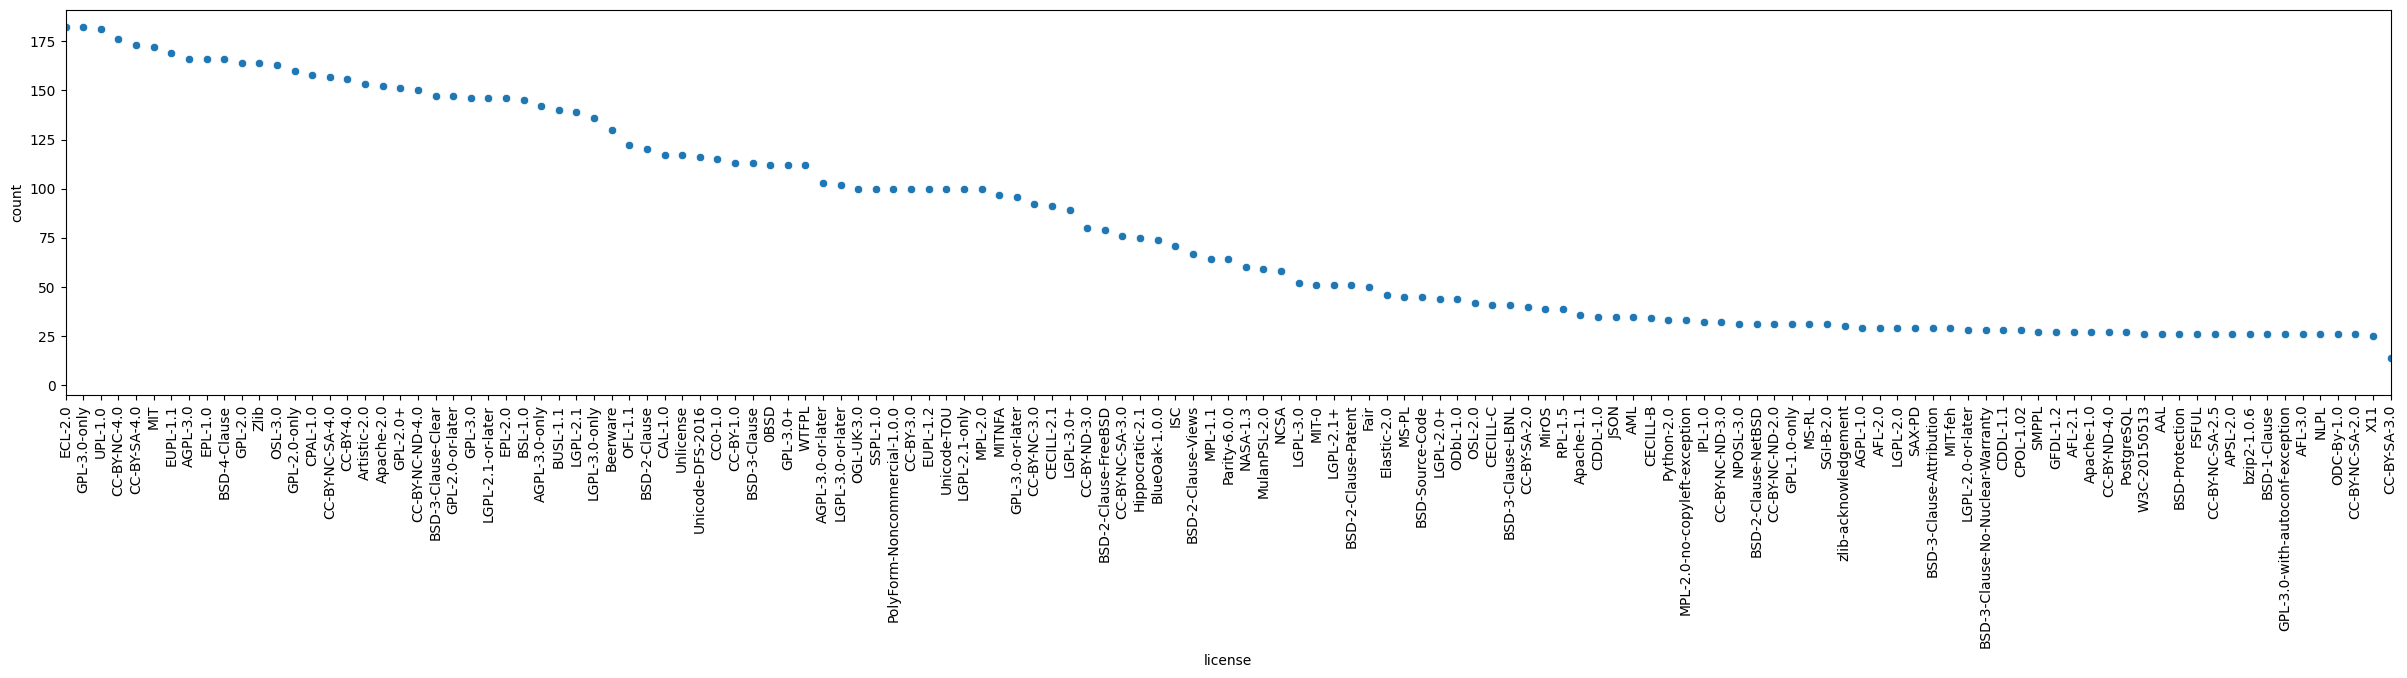

In [39]:
plt.figure(figsize=(30,5))
plt.xlim(0, 132)
plt.xticks(rotation=90)

sns.scatterplot(
    data=license_df,
    x="license", y="count",
)

### Add a new column `text_length` to view the distribution of liense text length

In [40]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df.head()

,text,license,word_count
0,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911
1,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911
2,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911
3,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911
4,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911


/home/mpcen/workspace/projects/web2/1es-hackathon/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x500 with 0 Axes>

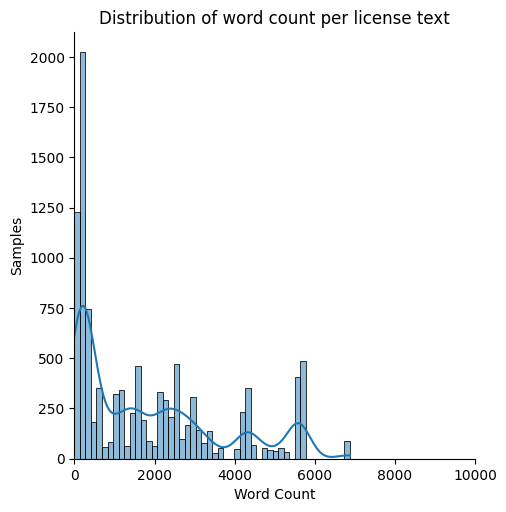

In [41]:
plt.figure(figsize=(20, 5))

sns.displot(df['word_count'], kde=True, bins=50)

plt.xlim(0, 10000)

plt.xlabel('Word Count')
plt.ylabel('Samples')
plt.title('Distribution of word count per license text')
plt.show()

### Investigating outliers

In [42]:
large_df = df[df['word_count'] > 7000]
large_df.head()

,text,license,word_count


## Prepare the train, test, and validation datasets

### Get a unique list of licenses

In [43]:
unique_license_list = license_df.license.unique().tolist()

print(unique_license_list)
print(len(unique_license_list))

['ECL-2.0', 'GPL-3.0-only', 'UPL-1.0', 'CC-BY-NC-4.0', 'CC-BY-SA-4.0', 'MIT', 'EUPL-1.1', 'AGPL-3.0', 'EPL-1.0', 'BSD-4-Clause', 'GPL-2.0', 'Zlib', 'OSL-3.0', 'GPL-2.0-only', 'CPAL-1.0', 'CC-BY-NC-SA-4.0', 'CC-BY-4.0', 'Artistic-2.0', 'Apache-2.0', 'GPL-2.0+', 'CC-BY-NC-ND-4.0', 'BSD-3-Clause-Clear', 'GPL-2.0-or-later', 'GPL-3.0', 'LGPL-2.1-or-later', 'EPL-2.0', 'BSL-1.0', 'AGPL-3.0-only', 'BUSL-1.1', 'LGPL-2.1', 'LGPL-3.0-only', 'Beerware', 'OFL-1.1', 'BSD-2-Clause', 'CAL-1.0', 'Unlicense', 'Unicode-DFS-2016', 'CC0-1.0', 'CC-BY-1.0', 'BSD-3-Clause', '0BSD', 'GPL-3.0+', 'WTFPL', 'AGPL-3.0-or-later', 'LGPL-3.0-or-later', 'OGL-UK-3.0', 'SSPL-1.0', 'PolyForm-Noncommercial-1.0.0', 'CC-BY-3.0', 'EUPL-1.2', 'Unicode-TOU', 'LGPL-2.1-only', 'MPL-2.0', 'MITNFA', 'GPL-3.0-or-later', 'CC-BY-NC-3.0', 'CECILL-2.1', 'LGPL-3.0+', 'CC-BY-ND-3.0', 'BSD-2-Clause-FreeBSD', 'CC-BY-NC-SA-3.0', 'Hippocratic-2.1', 'BlueOak-1.0.0', 'ISC', 'BSD-2-Clause-Views', 'MPL-1.1', 'Parity-6.0.0', 'NASA-1.3', 'MulanPSL-

### Create the license label mappings

In [44]:
id2Label = {str(i): label for i, label in enumerate(unique_license_list)}
label2id = {label: i for i, label in enumerate(unique_license_list)}

In [45]:
id2Label

{'0': 'ECL-2.0',
 '1': 'GPL-3.0-only',
 '2': 'UPL-1.0',
 '3': 'CC-BY-NC-4.0',
 '4': 'CC-BY-SA-4.0',
 '5': 'MIT',
 '6': 'EUPL-1.1',
 '7': 'AGPL-3.0',
 '8': 'EPL-1.0',
 '9': 'BSD-4-Clause',
 '10': 'GPL-2.0',
 '11': 'Zlib',
 '12': 'OSL-3.0',
 '13': 'GPL-2.0-only',
 '14': 'CPAL-1.0',
 '15': 'CC-BY-NC-SA-4.0',
 '16': 'CC-BY-4.0',
 '17': 'Artistic-2.0',
 '18': 'Apache-2.0',
 '19': 'GPL-2.0+',
 '20': 'CC-BY-NC-ND-4.0',
 '21': 'BSD-3-Clause-Clear',
 '22': 'GPL-2.0-or-later',
 '23': 'GPL-3.0',
 '24': 'LGPL-2.1-or-later',
 '25': 'EPL-2.0',
 '26': 'BSL-1.0',
 '27': 'AGPL-3.0-only',
 '28': 'BUSL-1.1',
 '29': 'LGPL-2.1',
 '30': 'LGPL-3.0-only',
 '31': 'Beerware',
 '32': 'OFL-1.1',
 '33': 'BSD-2-Clause',
 '34': 'CAL-1.0',
 '35': 'Unlicense',
 '36': 'Unicode-DFS-2016',
 '37': 'CC0-1.0',
 '38': 'CC-BY-1.0',
 '39': 'BSD-3-Clause',
 '40': '0BSD',
 '41': 'GPL-3.0+',
 '42': 'WTFPL',
 '43': 'AGPL-3.0-or-later',
 '44': 'LGPL-3.0-or-later',
 '45': 'OGL-UK-3.0',
 '46': 'SSPL-1.0',
 '47': 'PolyForm-Noncommerci

In [46]:
label2id

{'ECL-2.0': 0,
 'GPL-3.0-only': 1,
 'UPL-1.0': 2,
 'CC-BY-NC-4.0': 3,
 'CC-BY-SA-4.0': 4,
 'MIT': 5,
 'EUPL-1.1': 6,
 'AGPL-3.0': 7,
 'EPL-1.0': 8,
 'BSD-4-Clause': 9,
 'GPL-2.0': 10,
 'Zlib': 11,
 'OSL-3.0': 12,
 'GPL-2.0-only': 13,
 'CPAL-1.0': 14,
 'CC-BY-NC-SA-4.0': 15,
 'CC-BY-4.0': 16,
 'Artistic-2.0': 17,
 'Apache-2.0': 18,
 'GPL-2.0+': 19,
 'CC-BY-NC-ND-4.0': 20,
 'BSD-3-Clause-Clear': 21,
 'GPL-2.0-or-later': 22,
 'GPL-3.0': 23,
 'LGPL-2.1-or-later': 24,
 'EPL-2.0': 25,
 'BSL-1.0': 26,
 'AGPL-3.0-only': 27,
 'BUSL-1.1': 28,
 'LGPL-2.1': 29,
 'LGPL-3.0-only': 30,
 'Beerware': 31,
 'OFL-1.1': 32,
 'BSD-2-Clause': 33,
 'CAL-1.0': 34,
 'Unlicense': 35,
 'Unicode-DFS-2016': 36,
 'CC0-1.0': 37,
 'CC-BY-1.0': 38,
 'BSD-3-Clause': 39,
 '0BSD': 40,
 'GPL-3.0+': 41,
 'WTFPL': 42,
 'AGPL-3.0-or-later': 43,
 'LGPL-3.0-or-later': 44,
 'OGL-UK-3.0': 45,
 'SSPL-1.0': 46,
 'PolyForm-Noncommercial-1.0.0': 47,
 'CC-BY-3.0': 48,
 'EUPL-1.2': 49,
 'Unicode-TOU': 50,
 'LGPL-2.1-only': 51,
 'MPL-2.

### Add the license labels to a new column in the dataset

In [47]:
df["license_id"] = df.license.apply(lambda x: label2id[x])
df

,text,license,word_count,license_id
0,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911,97
1,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911,97
2,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911,97
3,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911,97
4,attribution-noncommercial-noderivs 2.0 copyrig...,CC-BY-NC-ND-2.0,1911,97
...,...,...,...,...
10895,mit license copyright (c) 2019 rolando santama...,MIT,170,5
10896,mit license copyright (c) 2019 rolando santama...,MIT,170,5
10897,mit license copyright (c) 2019 rolando santama...,MIT,170,5
10898,mit license copyright (c) 2019 rolando santama...,MIT,170,5


### Create the training, testing, and validation data splits

In [48]:
df['license_id'] = df['license_id'].astype('int')

dataset = Dataset.from_pandas(df)
dataset = DatasetDict({
    "train": dataset,
    "test": dataset,
    "validate": dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'license', 'word_count', 'license_id', '__index_level_0__'],
        num_rows: 10662
    })
    test: Dataset({
        features: ['text', 'license', 'word_count', 'license_id', '__index_level_0__'],
        num_rows: 10662
    })
    validate: Dataset({
        features: ['text', 'license', 'word_count', 'license_id', '__index_level_0__'],
        num_rows: 10662
    })
})

### Remove colum not needed

In [49]:
dataset["train"] = dataset["train"].remove_columns(["__index_level_0__"])
dataset["test"] = dataset["test"].remove_columns(["__index_level_0__"])
dataset["validate"] = dataset["validate"].remove_columns(["__index_level_0__"])
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'license', 'word_count', 'license_id'],
        num_rows: 10662
    })
    test: Dataset({
        features: ['text', 'license', 'word_count', 'license_id'],
        num_rows: 10662
    })
    validate: Dataset({
        features: ['text', 'license', 'word_count', 'license_id'],
        num_rows: 10662
    })
})

### Deduplicate the testing and validation datasets

In [50]:
print("Deduplicating the TEST datsset")

test_df = dataset['test'].to_pandas()
print(f"Before: {test_df.shape}")

test_df = test_df.drop_duplicates()
print(f"After: {test_df.shape}")


Deduplicating the TEST datsset
Before: (10662, 4)
After: (791, 4)


In [51]:
print("Deduplicating the VALIDATION datsset")

validate_df = dataset['validate'].to_pandas()

print(f"Before: {validate_df.shape}")

validate_df = validate_df.drop_duplicates()
print(f"After: {validate_df.shape}")

Deduplicating the VALIDATION datsset
Before: (10662, 4)
After: (791, 4)


<Axes: xlabel='license', ylabel='count'>

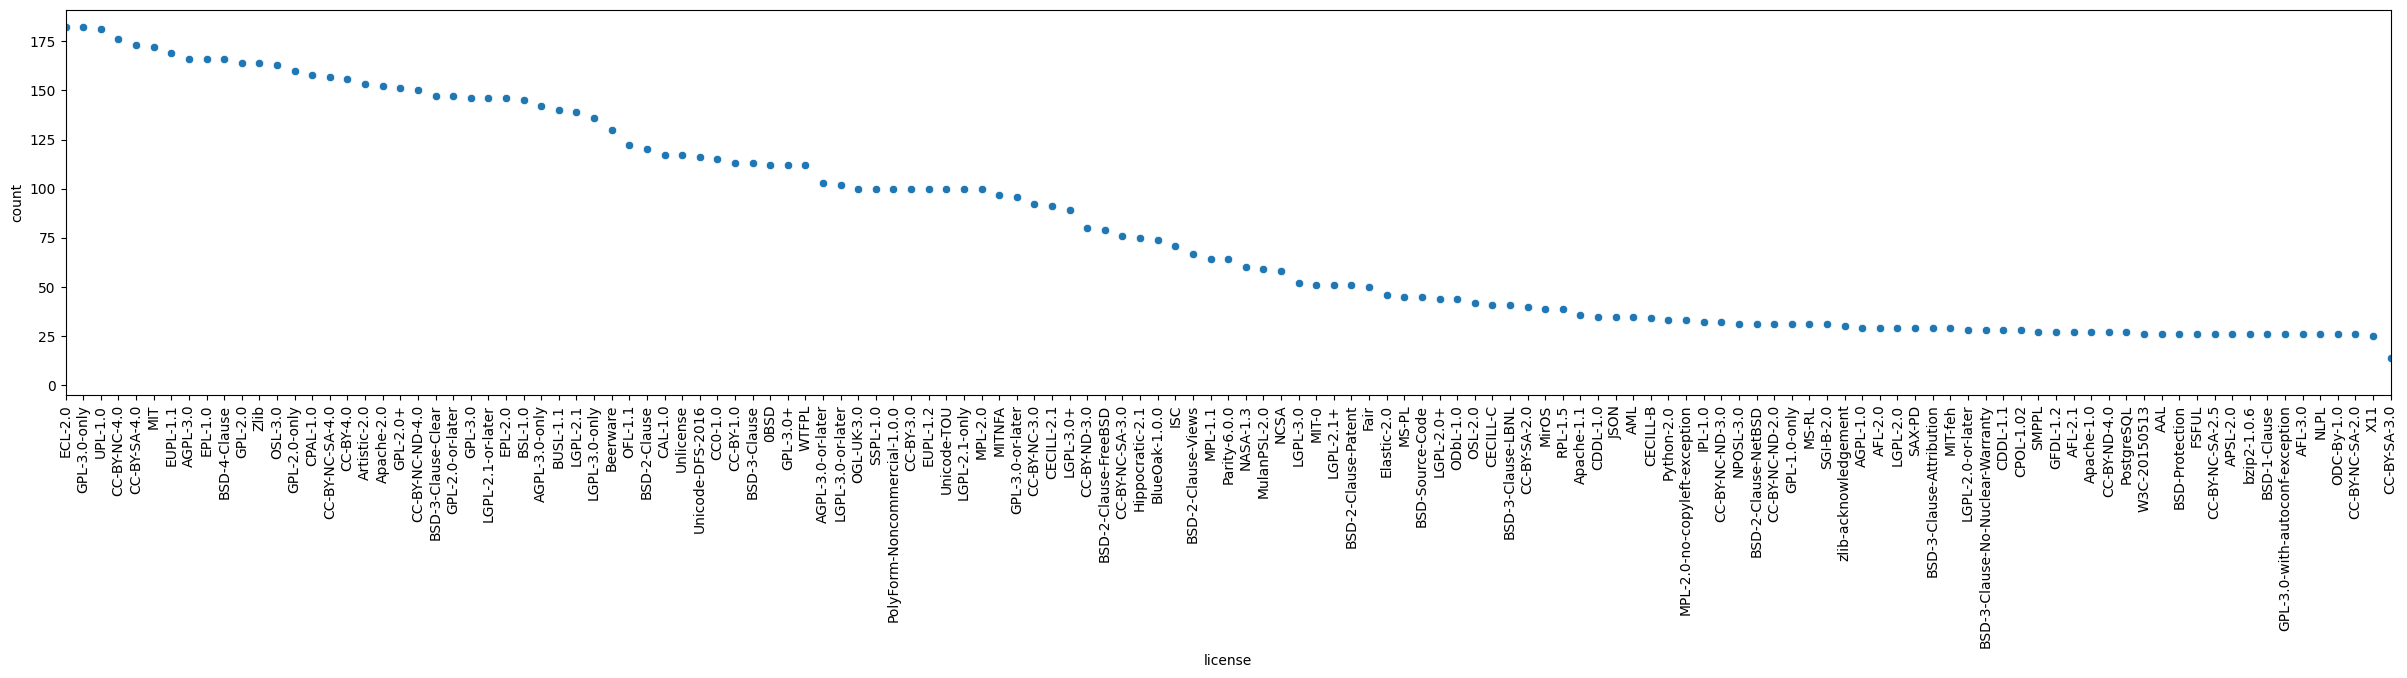

In [52]:
train_df = dataset['train'].to_pandas()
train_license_df = train_df['license'].value_counts().to_frame('count').rename_axis('license').reset_index()
train_license_df

plt.figure(figsize=(30,5))
plt.xlim(0, 132)
plt.xticks(rotation=90)

sns.scatterplot(
    data=train_license_df,
    x="license", y="count",
)

<Axes: xlabel='license', ylabel='count'>

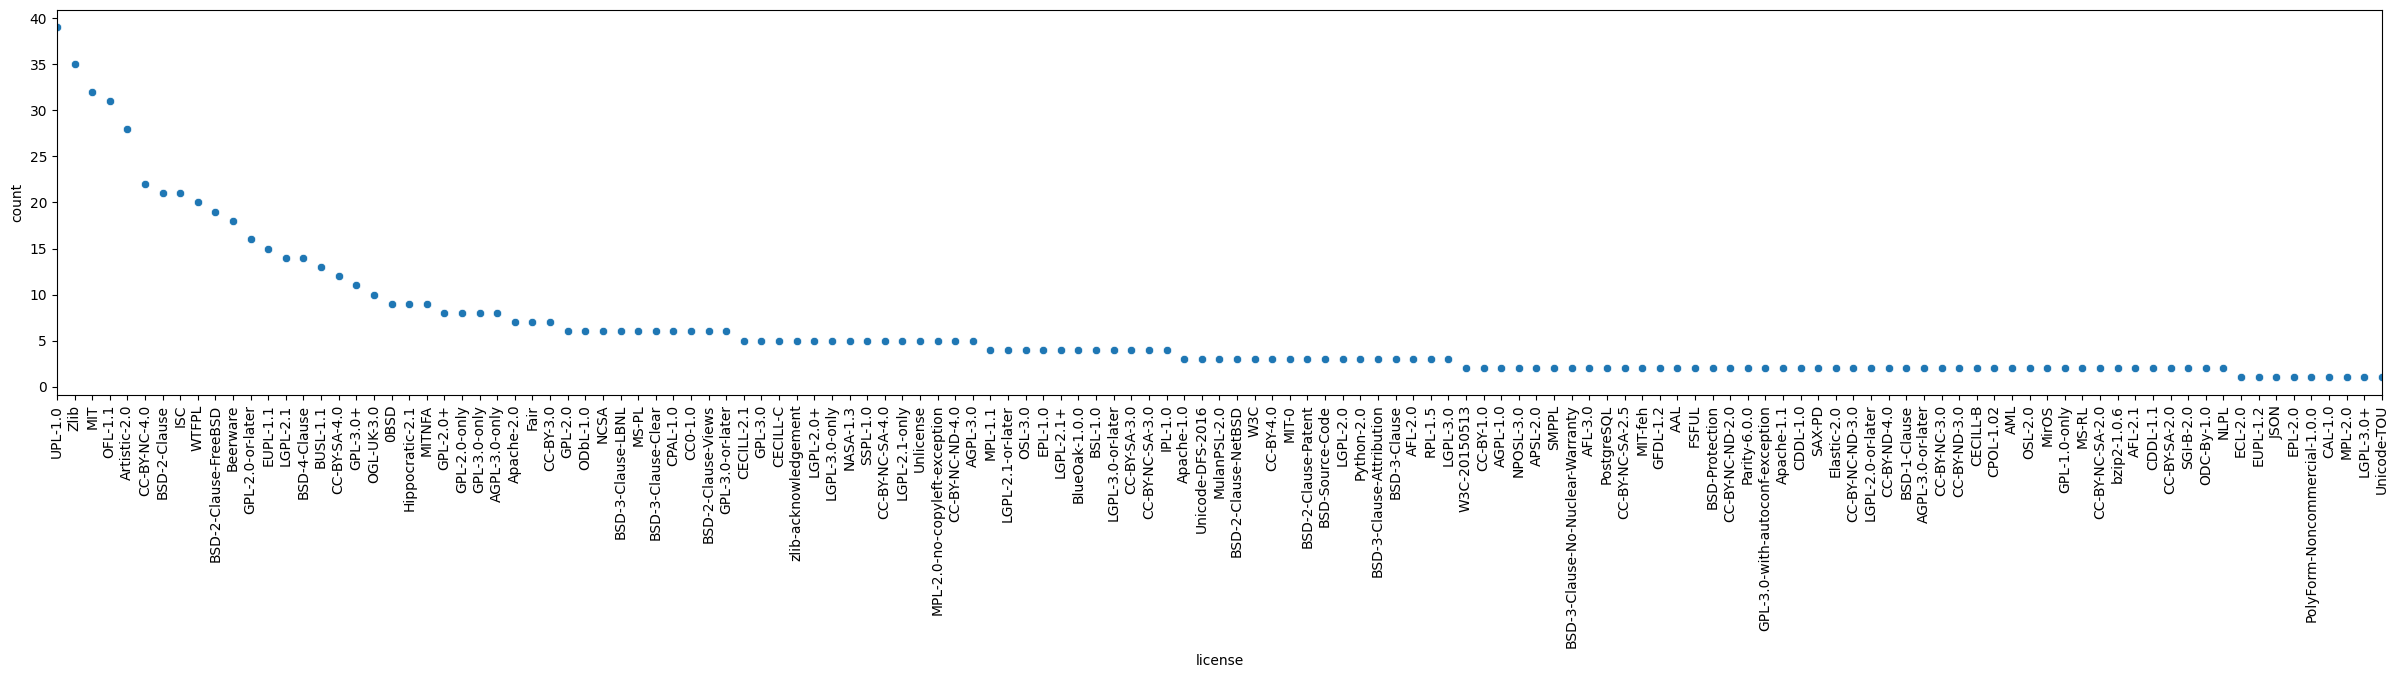

In [53]:
test_license_df = test_df['license'].value_counts().to_frame('count').rename_axis('license').reset_index()
test_license_df

plt.figure(figsize=(30,5))
plt.xlim(0, 132)
plt.xticks(rotation=90)

sns.scatterplot(
    data=test_license_df,
    x="license", y="count",
)

## Transform the datasets for training

### Define the checkpoint. Create the tokenizer & model

In [54]:
# BERT BASE - 512 max embeddings
# checkpoint = "bert-base-uncased"
# model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=len(unique_license_list))
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# 3rd Party - 1024 max embeddings
checkpoint = "Sreevishnu/funnel-transformer-small-imdb"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=len(unique_license_list), ignore_mismatched_sizes=True, max_position_embeddings=1024)
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of FunnelForSequenceClassification were not initialized from the model checkpoint at Sreevishnu/funnel-transformer-small-imdb and are newly initialized because the shapes did not match:
- classifier.linear_out.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([134, 768]) in the model instantiated
- classifier.linear_out.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([134]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Create the tokenize function

In [55]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors="pt")

### Tokenize the dataset and remove unnecessary columns

In [56]:
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text", "license", "word_count"])
tokenized_datasets = tokenized_datasets.rename_column("license_id", "labels")

Map:   0%|          | 0/10662 [00:00<?, ? examples/s]

### Define training arguments

In [58]:
training_args = TrainingArguments(
    output_dir="model_output",
    num_train_epochs=9,
    weight_decay=0.1,
    evaluation_strategy="epoch",
)

### Define metrics function

In [59]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Create the trainer

In [60]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validate"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

## Train the model!

In [61]:
trainer.train()

/home/mpcen/workspace/projects/web2/1es-hackathon/.venv/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a FunnelTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.862700,0.956749,0.717595
2,0.633000,0.517483,0.800694
3,0.540900,0.459026,0.817389
4,0.431500,0.385331,0.834834
5,0.386300,0.368359,0.840837
6,0.365200,0.341439,0.846089
7,0.344600,0.332478,0.851716
8,0.337800,0.323189,0.855468
9,0.316200,0.315452,0.859407


TrainOutput(global_step=11997, training_loss=0.6613386668810758, metrics={'train_runtime': 4423.8914, 'train_samples_per_second': 21.691, 'train_steps_per_second': 2.712, 'total_flos': 2.737484124862464e+16, 'train_loss': 0.6613386668810758, 'epoch': 9.0})

### Save the newly trained model and tokenizer

In [62]:
save_dir = "./saved_model"

model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

## Using the newly trained model and tokenizer

### Define the new model and tokenizer

In [63]:
legal_tokenizer = AutoTokenizer.from_pretrained(save_dir)
legal_model = AutoModelForSequenceClassification.from_pretrained(save_dir)

### Test the new model & tokenizer

In [65]:
import torch

license_text = """
apache license version 2.0, january 2004 http://www.apache.org/licenses/ terms and conditions for use, reproduction, and distribution 1. definitions. license shall mean the terms and conditions for use, reproduction, and distribution as defined by sections 1 through 9 of this document. licensor shall mean the copyright owner or entity authorized by the copyright owner that is granting the license. legal entity shall mean the union of the acting entity and all other entities that control, are controlled by, or are under common control with that entity. for the purposes of this definition, control means (i) the power, direct or indirect, to cause the direction or management of such entity, whether by contract or otherwise, or (ii) ownership of fifty percent (50%) or more of the outstanding shares, or (iii) beneficial ownership of such entity. you (or your) shall mean an individual or legal entity exercising permissions granted by this license. source form shall mean the preferred form for making modifications, including but not limited to software source code, documentation source, and configuration files. object form shall mean any form resulting from mechanical transformation or translation of a source form, including but not limited to compiled object code, generated documentation, and conversions to other media types. work shall mean the work of authorship, whether in source or object form, made available under the license, as indicated by a copyright notice that is included in or attached to the work (an example is provided in the appendix below). derivative works shall mean any work, whether in source or object form, that is based on (or derived from) the work and for which the editorial revisions, annotations, elaborations, or other modifications represent, as a whole, an original work of authorship. for the purposes of this license, derivative works shall not include works that remain separable from, or merely link (or bind by name) to the interfaces of, the work and derivative works thereof. contribution shall mean any work of authorship, including the original version of the work and any modifications or additions to that work or derivative works thereof, that is intentionally submitted to licensor for inclusion in the work by the copyright owner or by an individual or legal entity authorized to submit on behalf of the copyright owner. for the purposes of this definition, submitted means any form of electronic, verbal, or written communication sent to the licensor or its representatives, including but not limited to communication on electronic mailing lists, source code control systems, and issue tracking systems that are managed by, or on behalf of, the licensor for the purpose of discussing and improving the work, but excluding communication that is conspicuously marked or otherwise designated in writing by the copyright owner as not a contribution. contributor shall mean licensor and any individual or legal entity on behalf of whom a contribution has been received by licensor and subsequently incorporated within the work. 2. grant of copyright license. subject to the terms and conditions of this license, each contributor hereby grants to you a perpetual, worldwide, non-exclusive, no-charge, royalty-free, irrevocable copyright license to reproduce, prepare derivative works of, publicly display, publicly perform, sublicense, and distribute the work and such derivative works in source or object form. 3. grant of patent license. subject to the terms and conditions of this license, each contributor hereby grants to you a perpetual, worldwide, non-exclusive, no-charge, royalty-free, irrevocable (except as stated in this section) patent license to make, have made, use, offer to sell, sell, import, and otherwise transfer the work, where such license applies only to those patent claims licensable by such contributor that are necessarily infringed by their contribution(s) alone or by combination of their contribution(s) with the work to which such contribution(s) was submitted. if you institute patent litigation against any entity (including a cross-claim or counterclaim in a lawsuit) alleging that the work or a contribution incorporated within the work constitutes direct or contributory patent infringement, then any patent licenses granted to you under this license for that work shall terminate as of the date such litigation is filed. 4. redistribution. you may reproduce and distribute copies of the work or derivative works thereof in any medium, with or without modifications, and in source or object form, provided that you meet the following conditions: (a) you must give any other recipients of the work or derivative works a copy of this license; and (b) you must cause any modified files to carry prominent notices stating that you changed the files; and (c) you must retain, in the source form of any derivative works that you distribute, all copyright, patent, trademark, and attribution notices from the source form of the work, excluding those notices that do not pertain to any part of the derivative works; and (d) if the work includes a notice text file as part of its distribution, then any derivative works that you distribute must include a readable copy of the attribution notices contained within such notice file, excluding those notices that do not pertain to any part of the derivative works, in at least one of the following places: within a notice text file distributed as part of the derivative works; within the source form or documentation, if provided along with the derivative works; or, within a display generated by the derivative works, if and wherever such third-party notices normally appear. the contents of the notice file are for informational purposes only and do not modify the license. you may add your own attribution notices within derivative works that you distribute, alongside or as an addendum to the notice text from the work, provided that such additional attribution notices cannot be construed as modifying the license. you may add your own copyright statement to your modifications and may provide additional or different license terms and conditions for use, reproduction, or distribution of your modifications, or for any such derivative works as a whole, provided your use, reproduction, and distribution of the work otherwise complies with the conditions stated in this license. 5. submission of contributions. unless you explicitly state otherwise, any contribution intentionally submitted for inclusion in the work by you to the licensor shall be under the terms and conditions of this license, without any additional terms or conditions. notwithstanding the above, nothing herein shall supersede or modify the terms of any separate license agreement you may have executed with licensor regarding such contributions. 6. trademarks. this license does not grant permission to use the trade names, trademarks, service marks, or product names of the licensor, except as required for reasonable and customary use in describing the origin of the work and reproducing the content of the notice file. 7. disclaimer of warranty. unless required by applicable law or agreed to in writing, licensor provides the work (and each contributor provides its contributions) on an as is basis, without warranties or conditions of any kind, either express or implied, including, without limitation, any warranties or conditions of title, non-infringement, merchantability, or fitness for a particular purpose. you are solely responsible for determining the appropriateness of using or redistributing the work and assume any risks associated with your exercise of permissions under this license. 8. limitation of liability. in no event and under no legal theory, whether in tort (including negligence), contract, or otherwise, unless required by applicable law (such as deliberate and grossly negligent acts) or agreed to in writing, shall any contributor be liable to you for damages, including any direct, indirect, special, incidental, or consequential damages of any character arising as a result of this license or out of the use or inability to use the work (including but not limited to damages for loss of goodwill, work stoppage, computer failure or malfunction, or any and all other commercial damages or losses), even if such contributor has been advised of the possibility of such damages. 9. accepting warranty or additional liability. while redistributing the work or derivative works thereof, you may choose to offer, and charge a fee for, acceptance of support, warranty, indemnity, or other liability obligations and/or rights consistent with this license. however, in accepting such obligations, you may act only on your own behalf and on your sole responsibility, not on behalf of any other contributor, and only if you agree to indemnify, defend, and hold each contributor harmless for any liability incurred by, or claims asserted against, such contributor by reason of your accepting any such warranty or additional liability. end of terms and conditions appendix: how to apply the apache license to your work. to apply the apache license to your work, attach the following boilerplate notice, with the fields enclosed by brackets [] replaced with your own identifying information. (don't include the brackets!) the text should be enclosed in the appropriate comment syntax for the file format. we also recommend that a file or class name and description of purpose be included on the same printed page as the copyright notice for easier identification within third-party archives. copyright [yyyy] [name of copyright owner] licensed under the apache license, version 2.0 (the license); you may not use this file except in compliance with the license. you may obtain a copy of the license at http://www.apache.org/licenses/license-2.0 unless required by applicable law or agreed to in writing, software distributed under the license is distributed on an as is basis, without warranties or conditions of any kind, either express or implied. see the license for the specific language governing permissions and limitations under the license.
"""

def test_license(license_text):
    tokenized_input = legal_tokenizer(license_text, truncation=True, padding=True, return_tensors="pt")
    output = legal_model(**tokenized_input)
    prediction_value = torch.argmax(output.logits).item()
    result = id2Label[str(prediction_value)]
    return result

test_license(license_text)

'Apache-2.0'